# Intro to QSAR Modeling

Machine Learning has been applied to a variety of problems such as image and voice recognition and more recently into chemistry.   The idea is that computers can "learn" certain features or properties of chemicals and use them to predict some sort of biological activity.  There are dozens of different Machine Learning algorithms.

Let's walk through a typical workflow.  First we need to load are molecules.  

In [1]:
from rdkit import Chem 
import pandas as pd

fhmds = pd.read_csv('data/FHMDB.csv')

fhmds.index = fhmds.NAME

mols = []
names = []
for name, smiles in fhmds.SMILES.iteritems():
    if Chem.MolFromSmiles(smiles):
        mols.append(Chem.MolFromSmiles(smiles))
        names.append(name)

print("Rdkit created {} mols".format(len(mols)))

Rdkit created 745 mols


In calculating chemical similarity, we used chemical fingerprints: binary representations of molecules denoting the presence or absence of chemical fragments.  

Another widely use way to represent molecules is known as molecular descriptors.  Just as there were several different versions of fingerprints, as is the same for molecular descriptors.  Many different software packages exist to create them.  They can range from just a few to a few thousand.  For this notebook, we'll use the molecular descriptors provided within the rdkit package.  

In [2]:
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import Descriptors

calc = MoleculeDescriptors.MolecularDescriptorCalculator([desc[0] for desc in Descriptors.descList])

descriptors = pd.DataFrame([list(calc.CalcDescriptors(mol)) for mol in mols],
                     columns=list(calc.GetDescriptorNames()), index=names)
descriptors.head()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
4-(HEXYLOXY)-M-ANISALDEHYDE,10.621839,0.597392,10.621839,0.597392,0.511880,236.311,216.151,236.141244,94,0,...,0,0,0,0,0,0,0,0,3,0
5-BROMO-2-NITROVANILLIN,10.664142,-0.783009,10.664142,0.159306,0.516841,276.042,269.994,274.942934,80,0,...,0,0,0,0,0,0,0,0,0,0
DI-N-OCTYLISOPHTHALATE,12.165863,-0.375803,12.165863,0.375803,0.232089,390.564,352.260,390.277010,158,0,...,0,0,0,0,0,0,0,0,10,0
P-CHLOROPHENYL-O-NITROPHENYL ETHER,10.770527,-0.480901,10.770527,0.067176,0.609256,249.653,241.589,249.019271,86,0,...,0,0,0,0,0,0,0,0,0,0
3'-CHLORO-O-FORMOTOLUIDIDE,10.083590,0.637562,10.083590,0.637562,0.676245,169.611,161.547,169.029442,58,0,...,0,0,0,0,0,0,0,0,0,0


As you can see, the molecular descriptors are a bit more complex than presence or absence of fragments.  They're real, continuous numbers.  One immediate problem we see is that they all exist in different scales.  One important preprocessing step for most ML algorithms.  scitkit-learn has a whole module dedicated to preprocessing data.  We'll import their function for scaling.  Which centers the mean to zero and gives unit varience. 

Before we do that, it's important to check that all the values are were created.  Sometimes, there are errors created descriptors for some molecules.  These are ususally stored as NaN values.  

In [3]:
descriptors.isnull().sum().sum()

12

There are 12 such of these instances.  We can just remove those compounds, because they may interfere with our algorithms.  

In [4]:
descriptors = descriptors[~descriptors.isnull().any(1)]

print("There are {} compounds remaining.".format(descriptors.shape[0]))

There are 742 compounds remaining.


In [5]:
from sklearn.preprocessing import scale

descriptors = pd.DataFrame(scale(descriptors), index=descriptors.index, columns=descriptors.columns)

descriptors.head()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
4-(HEXYLOXY)-M-ANISALDEHYDE,0.742904,0.603866,0.742904,0.334636,-0.192219,0.815411,0.722075,0.821289,1.246412,0.0,...,-0.144251,-0.036736,0.0,-0.131248,0.0,-0.036736,0.0,-0.036736,1.358004,-0.090289
5-BROMO-2-NITROVANILLIN,0.756835,-0.678992,0.756835,-0.675815,-0.149090,1.309985,1.409933,1.306120,0.720082,0.0,...,-0.144251,-0.036736,0.0,-0.131248,0.0,-0.036736,0.0,-0.036736,-0.354697,-0.090289
DI-N-OCTYLISOPHTHALATE,1.251371,-0.300561,1.251371,-0.176460,-2.624580,2.735562,2.460903,2.747231,3.652493,0.0,...,-0.144251,-0.036736,0.0,-0.131248,0.0,-0.036736,0.0,-0.036736,5.354305,-0.090289
P-CHLOROPHENYL-O-NITROPHENYL ETHER,0.791869,-0.398232,0.791869,-0.888313,0.654327,0.981493,1.047052,0.982201,0.945652,0.0,...,-0.144251,-0.036736,0.0,-0.131248,0.0,-0.036736,0.0,-0.036736,-0.354697,-0.090289
3'-CHLORO-O-FORMOTOLUIDIDE,0.565651,0.641198,0.565651,0.427288,1.236695,-0.014875,0.024495,-0.017280,-0.107009,0.0,...,-0.144251,-0.036736,0.0,-0.131248,0.0,-0.036736,0.0,-0.036736,-0.354697,-0.090289


In [6]:
% matplotlib inline

Now that we have descriptors for everything in our dataset, things can start looking interesting when we relate it to activity.  Since we are looking at fathead minnow death, the activity is LC50.  Lets see how they are distributed.  It's common to look at the log transformed values.

Lets remove negative numbers....theyre just listed there as an alternative to NaNs. 

In [7]:
lc50 = fhmds.LC50[fhmds.LC50 > 0]
lc50 = lc50[lc50.index.isin(descriptors.index)]
descriptors = descriptors.loc[lc50.index]

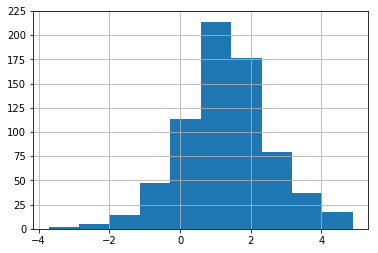

In [8]:
import math 

plc50 = lc50.apply(math.log10)

plc50.hist()

It seems that values are normally distributed, with most of the compounds around log10(lc50) == 1.  We will make our QSAR module a _classification_ model.  Meaning well just and predict, toxic or not toxic.  We can say everything less than 1 is toxic, and greater than 1, non-toxic.  From here on out well, call toxic == 1, and non-toxic 0.

In [9]:
classes = plc50.copy()
classes[plc50 < 1] = 1
classes[plc50 >= 1] = 0

print("There are {} toxic molecules and {} non-toxic molecules using this classification".format((classes == 1).sum(), 
                                                                                                 (classes == 0).sum()))

There are 276 toxic molecules and 429 non-toxic molecules using this classification


In [10]:
classes.shape

(705,)

Let's see the the differences in the means for the molecular descriptors between toxic and non-toxic compounds.

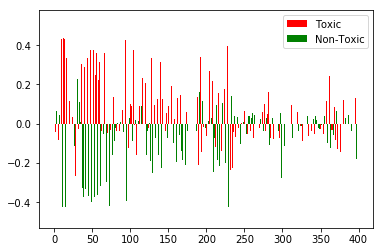

In [12]:
import numpy as np
import matplotlib.pyplot as plt

xs = np.arange(0, descriptors.shape[1]*2, 2)

plt.bar(xs, descriptors[classes == 1].mean(), color='red', label='Toxic')
plt.bar(xs+1, descriptors[classes == 0].mean(), color='green', label='Non-Toxic')
plt.legend()

Definitely looks like there's some differneces in the features between active and inactive.  Let's prepare the data for QSAR.  Generally, the way to 'train' the model is using [5-fold cross validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics).  Then we predict using a set of compounds we reserved.  Scikit-learn still has functions for both these.  We'll reserve 20% of the compounds for a test set.

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(descriptors, classes, test_size=0.2, random_state=0)

Let's prepare a few algorithms.  

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

models = {'RF': RandomForestClassifier(), 'SVC': SVC(), 'LR':LogisticRegression()}



First, let's see how the models perform predicting chemicals in the training set.  That is, how they perform using 5-fold cross validation.  

In [15]:
from sklearn.model_selection import cross_val_score

for name, mdl in models.items():
    scores = cross_val_score(mdl, 
                             X_train, 
                             y_train, 
                             cv=5, scoring='accuracy')
    print('Accuracy score on training set for {}: {}'.format(name, scores.mean()))

Accuracy score on training set for RF: 0.8262908377137533
Accuracy score on training set for SVC: 0.805018630647415
Accuracy score on training set for LR: 0.838773648723579


The scores aren't too bad.  For each algorithm, the prediction is right between 80-84% of the time.  However, a common phenomenon in Machine Learning is the idea of 'over-fitting' or 'over-training' a model.  Given enough training time and parameter adjustment, a model is going to be able to 'learn' the data it's being trained on.  More accurately, it can be thought of 'memorizing' the training data.  This is precisely the reason we reserve a test set for and external validation.  That is, compounds that the model has never seen before.  

In [16]:
from sklearn.metrics import accuracy_score

for name, mdl in models.items():
    mdl.fit(X_train, y_train)
    predictions = mdl.predict(X_test)
    print('Accuracy score on test set for {}: {}'.format(name, accuracy_score(y_test, predictions)))

Accuracy score on test set for RF: 0.7730496453900709
Accuracy score on test set for SVC: 0.7588652482269503
Accuracy score on test set for LR: 0.7872340425531915


We see a marked decrease in the model performance: about 5%.  Still however, the models are pretty accurate, predicting toxic or non-toxic compounds at an accuracy of ~75-79%.